In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from scipy.conftest import num_parallel_threads

import my_afml_fncs as my_afml
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

LOAD DATA

In [2]:
filename_end="2019_2024"
volume_bars_df=pd.read_csv(f'tick_data/bars/volume_bars_barchart_{filename_end}.csv')
volume_bars_df['bar_number'] = range(len(volume_bars_df))
dollar_bars_df=pd.read_csv(f'tick_data/bars/dollar_bars_barchart_{filename_end}.csv')
dollar_bars_df['bar_number'] = range(len(dollar_bars_df))

Convert to datetime and set it to index

In [3]:
volume_bars_df['Date']=pd.to_datetime(volume_bars_df['Date'])
volume_bars_df.set_index('Date',inplace=True)
dollar_bars_df['Date']=pd.to_datetime(dollar_bars_df['Date'])
dollar_bars_df.set_index('Date',inplace=True)
dollar_bars_df.sort_index(inplace=True)
volume_bars_df.sort_index(inplace=True)

Create an array of daily vols

In [4]:
volume_vol=my_afml.getDailyVol(volume_bars_df.Close)
dollar_vol=my_afml.getDailyVol(dollar_bars_df.Close)

Build a cusum filter as a possible feature. Used earlier in 3.1

In [5]:
# # 3.1(a) apply CUSUM filet usings daily vols
# es_cusum_events=my_afml.getTEvents(volume_bars_df.Close,vol.mean())
# print('Volume bar CUSUM events:',es_cusum_events.shape)
# dollar_es_cusum_events=my_afml.getTEvents(dollar_bars_df.Close,dollar_vol.mean())
# print('Dollar bar CUSUM events:',dollar_es_cusum_events.shape)

Define moving average params

In [6]:
# Start of 3.4
# Define moving average windows
short_window = 20  # e.g., 50 periods
long_window = 50  # e.g., 200 periods

Create events array where the moving average switches from in to out for volume bars


In [7]:
# create events where the moving averages cross over
volume_events = my_afml.movingAverageCrossover(volume_bars_df.Close, short_window, long_window)
volume_events = volume_events.dropna()
# try this with a crossover signa change
volume_events['signal_switch'] = (volume_events.signal.diff()/ 2)
# drop rows with any NaN values
volume_events = volume_events.dropna()
# filter rows where signal_switch is not zero
volume_events = volume_events[volume_events['signal_switch'] != 0]

Create events array where the moving average switches from in to out for dollar bars


In [8]:
# create events where the moving averages cross over
dollar_events = my_afml.movingAverageCrossover(dollar_bars_df.Close, short_window, long_window)
# try this with a crossover sign change
dollar_events['signal_switch'] = dollar_events.signal.diff() / 2
# drop rows with any NaN values
dollar_events = dollar_events.dropna()
# filter rows where signal_switch is not zero
dollar_events = dollar_events[dollar_events['signal_switch'] != 0]

Define vertical barriers

In [9]:
# and add vertical barrier 1 day from those events (as close to 1 day as possible?)
volume_t1=my_afml.getVb(volume_bars_df.Close, volume_events.index)
dollar_t1=my_afml.getVb(dollar_bars_df.Close,dollar_events.index)

Create meta-labels: uses the expanded getEvents to return t1 which is the timestamp the barrier was first touched and trgt which is the target that was used to generate the horizontal barrier, the expanded version accetpts a side too (and also returns it)


In [10]:
# Now create the meta-labels using the primary model (which provides the side from the crossover point), the t1 vertical barrier which is as close to 1 day as possible from the crossover. We don't label anything as primary model as that was the simple crossover. Meta-labels are used for secondary model.
# now set ptsl to be lopsided [1,2] which we can do because we now have a 'side' from the moving average crossover. Trigger has column called 'side'
ptsl=[1,2]
# target is set to be standard deviation
trgt= volume_vol * volume_bars_df.Close
# trgt is variable but we can set a fixed minimum return
minRet=0.00003
numThread=128
# get events will find time of first touch after each event
volume_trigger_secondary_model=my_afml.getEvents(volume_bars_df.Close, volume_events.index, ptsl, trgt, minRet, numThread, volume_t1, volume_events.signal)


Running processJobs


2025-03-13 10:38:57.832017 100.0% applyPtSlOnT1 done after 0.03 minutes. Remaining 0.0 minutes.


In [11]:
# trgt= volume_vol.mean() * volume_bars_df.Close


In [12]:
#and for dollar bars
ptsl=[1,2]
# target is set to be standard deviation
dollar_trgt=dollar_vol*dollar_bars_df.Close
# trgt is variable but we can set a fixed minimum return minRet=0.00003
numThread=128
# get events will find time of first touch after each event
dollar_trigger_secondary_model=my_afml.getEvents(dollar_bars_df.Close, dollar_events.index, ptsl, dollar_trgt, minRet, numThread, dollar_t1, dollar_events.signal)

Running processJobs


025-03-13 10:39:10.128122 63.28% applyPtSlOnT1 done after 0.17 minutes. Remaining 0.1 minutes.2025-03-13 10:39:10.376060 64.84% applyPtSlOnT1 done after 0.18 minutes. Remaining 0.1 minutes.2025-03-13 10:39:10.627167 66.41% applyPtSlOnT1 done after 0.18 minutes. Remaining 0.09 minutes.2025-03-13 10:39:10.881794 67.97% applyPtSlOnT1 done after 0.19 minutes. Remaining 0.09 minutes.2025-03-13 10:39:11.137364 69.53% applyPtSlOnT1 done after 0.19 minutes. Remaining 0.08 minutes.2025-03-13 10:39:11.385953 71.09% applyPtSlOnT1 done after 0.19 minutes. Remaining 0.08 minutes.2025-03-13 10:39:11.642157 72.66% applyPtSlOnT1 done after 0.2 minutes. Remaining 0.07 minutes.2025-03-13 10:39:11.894203 74.22% applyPtSlOnT1 done after 0.2 minutes. Remaining 0.07 minutes.2025-03-13 10:39:12.385682 76.56% applyPtSlOnT1 done after 0.21 minutes. Remaining 0.06 minutes.2025-03-13 10:39:12.637982 78.12% applyPtSlOnT1 done after 0.21 minutes. Remaining 0.06 minutes.2025-03-13 10:39:12.889770 79.69% applyPtSlOn

Generate the bins using the triggers
The expanded get bins with a side returns 0 or 1 rather than -1, 0 or 1. So 1 is take the bet and 0 is pass (the side is already determined) and when the this secondary prediction is 1 we use the probability to size the bet!

The getBins function adds labels to the events returned by getEvents and returns the realized return of the first touched barrier and bin which is either -1,0,+1 which is the sign of the return or 0,1 if we know the side.

In [13]:
# getBins will generate the meta-label as we provide a side now in trigger
volume_bins_secondary_model=my_afml.getBins(volume_trigger_secondary_model, volume_bars_df.Close)
dollar_bins_secondary_model=my_afml.getBins(dollar_trigger_secondary_model,dollar_bars_df.Close)

In [14]:
# volume_bins_secondary_model.head()

In [15]:
# dollar_bins_secondary_model.head()

In [16]:
# add the crossover data and std to volume_bars for the secondary model
volume_bars_df[['short_ma', 'long_ma', 'signal']] = my_afml.movingAverageCrossover(volume_bars_df.Close, short_window, long_window)
volume_bars_df['std']=my_afml.getDailyVol(volume_bars_df.Close)
dollar_bars_df[['short_ma', 'long_ma', 'signal']] = my_afml.movingAverageCrossover(dollar_bars_df.Close, short_window, long_window)
dollar_bars_df['std']=my_afml.getDailyVol(dollar_bars_df.Close)


In [17]:
# now fit same data using these labels
volume_X= volume_bars_df.loc[volume_bins_secondary_model.index, :]
volume_y=volume_bins_secondary_model['bin']

In [18]:

# Prepare the data
features = volume_X
features.reset_index(drop=True, inplace=True)
features = features.drop(columns=['Symbol'])
labels = volume_y

In [19]:
 # Target variable
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Train RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.5766823161189358
              precision    recall  f1-score   support

         0.0       0.57      0.58      0.57       625
         1.0       0.59      0.57      0.58       653

    accuracy                           0.58      1278
   macro avg       0.58      0.58      0.58      1278
weighted avg       0.58      0.58      0.58      1278



In [20]:
# now fit same data using these labels
dollar_X=dollar_bars_df.loc[dollar_bins_secondary_model.index,:]
dollar_y=dollar_bins_secondary_model['bin']

# Prepare the data
features = dollar_X
features.reset_index(drop=True, inplace=True)
features = features.drop(columns=['Symbol'])
labels = dollar_y  # Target variable
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Train RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.7512481007163013
              precision    recall  f1-score   support

         0.0       0.74      0.77      0.75      4562
         1.0       0.77      0.73      0.75      4652

    accuracy                           0.75      9214
   macro avg       0.75      0.75      0.75      9214
weighted avg       0.75      0.75      0.75      9214



In [21]:
ptsl=[1,1]
# target is set to be standard deviation
dollar_trgt=dollar_vol*dollar_bars_df.Close
# trgt is variable but we can set a fixed minimum return minRet=0.00003
numThread=128
# get events will find time of first touch after each event
dollar_trigger_secondary_model=my_afml.getEvents(dollar_bars_df.Close, dollar_events.index, ptsl, dollar_trgt, minRet, numThread, dollar_t1)


Running processJobs


2025-03-13 10:39:43.978296 100.0% applyPtSlOnT1 done after 0.23 minutes. Remaining 0.0 minutes.


In [22]:
numThreads=128
out=pd.DataFrame()
close=dollar_bars_df.Close
events=dollar_trigger_secondary_model

In [23]:

numCoEvents=my_afml.mpPandasObj(my_afml.mpNumCoEvents,('molecule',events.index),numThreads, \
closeIdx=close.index,t1=events['t1'])

Running processJobs


2025-03-13 10:39:49.727895 100.0% mpNumCoEvents done after 0.05 minutes. Remaining 0.0 minutes.


In [24]:
# Calculate exponentially weighted moving standard deviation of returns of close
returns = close.pct_change()  # Calculate returns
ewm_std = returns.ewm(span=20).std()  # Calculate exponentially weighted moving standard deviation
ewm_std.name = 'ewm_std'
ewm_std.head()

Date
2018-12-31 06:00:00         NaN
2018-12-31 06:12:00         NaN
2018-12-31 06:33:00    0.000212
2018-12-31 06:41:00    0.000575
2018-12-31 06:50:00    0.000696
Name: ewm_std, dtype: float64

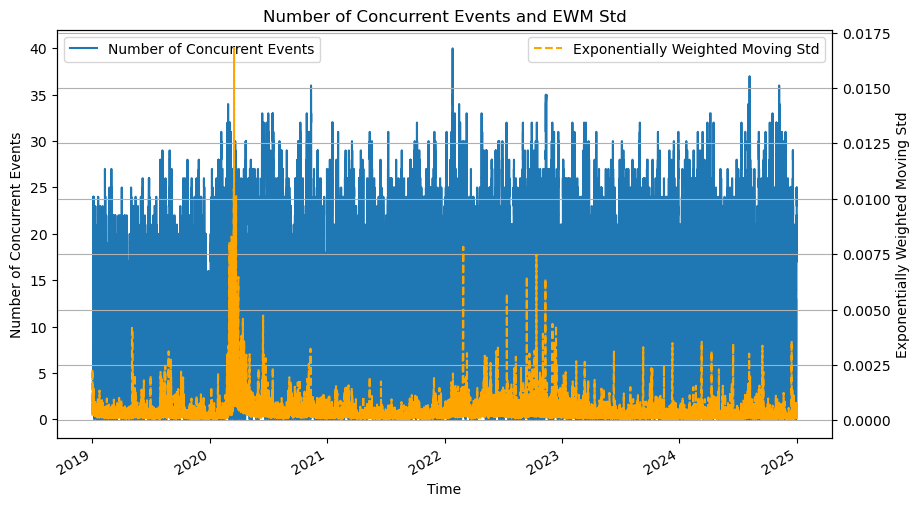

In [25]:
# Plot numCoEvents and ewm_std
plt.figure(figsize=(10, 6))
ax = numCoEvents.plot(label="Number of Concurrent Events", figsize=(10, 6))
ax2 = ax.twinx()  # Create a secondary axis
ewm_std.plot(ax=ax2, label="Exponentially Weighted Moving Std", linestyle='--', color='orange')
ax.set_title("Number of Concurrent Events and EWM Std")
ax.set_xlabel("Time")
ax.set_ylabel("Number of Concurrent Events")
ax2.set_ylabel("Exponentially Weighted Moving Std")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.grid()
plt.show()

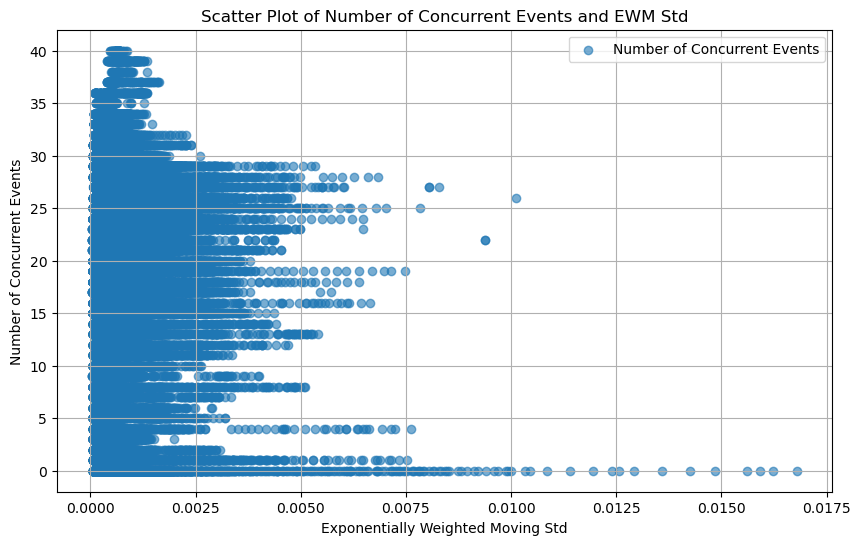

In [26]:
# Align numCoEvents and ewm_std
numCoEvents_aligned, ewm_std_aligned = numCoEvents.align(ewm_std, join='inner')

# Scatter plot numCoEvents vs. ewm_std
plt.figure(figsize=(10, 6))
plt.scatter(ewm_std_aligned, numCoEvents_aligned, label="Number of Concurrent Events", alpha=0.6)
plt.title("Scatter Plot of Number of Concurrent Events and EWM Std")
plt.xlabel("Exponentially Weighted Moving Std")
plt.ylabel("Number of Concurrent Events")
plt.legend()
plt.grid()
plt.show()

In [27]:
numCoEvents=numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]

In [28]:
numCoEvents=numCoEvents.reindex(close.index).fillna(0)

In [29]:
out['tW']=my_afml.mpPandasObj(my_afml.mpSampleTW,('molecule',events.index),numThreads, \
t1=events['t1'],numCoEvents=numCoEvents)


Running processJobs


025-03-13 10:40:05.426457 13.28% mpSampleTW done after 0.05 minutes. Remaining 0.3 minutes.2025-03-13 10:40:05.739333 14.84% mpSampleTW done after 0.05 minutes. Remaining 0.29 minutes.2025-03-13 10:40:06.056260 16.41% mpSampleTW done after 0.06 minutes. Remaining 0.28 minutes.2025-03-13 10:40:06.369359 17.97% mpSampleTW done after 0.06 minutes. Remaining 0.28 minutes.2025-03-13 10:40:06.683820 19.53% mpSampleTW done after 0.07 minutes. Remaining 0.27 minutes.2025-03-13 10:40:06.995603 21.09% mpSampleTW done after 0.07 minutes. Remaining 0.27 minutes.2025-03-13 10:40:07.306665 22.66% mpSampleTW done after 0.08 minutes. Remaining 0.26 minutes.2025-03-13 10:40:07.619670 24.22% mpSampleTW done after 0.08 minutes. Remaining 0.26 minutes.2025-03-13 10:40:07.932256 25.78% mpSampleTW done after 0.09 minutes. Remaining 0.25 minutes.2025-03-13 10:40:08.248287 27.34% mpSampleTW done after 0.09 minutes. Remaining 0.25 minutes.2025-03-13 10:40:08.562477 28.91% mpSampleTW done after 0.1 minutes. Rem

In [30]:
serial_correlation = out['tW'].autocorr()
print(f"Serial Correlation of 'tW': {serial_correlation}")

Serial Correlation of 'tW': 0.6905269878789451


In [31]:
from scipy.stats import t

# Number of observations in 'tW' (degrees of freedom = n-2 for correlation)
n = out['tW'].dropna().shape[0]

# Compute statistical significance (two-tailed test for correlation)
t_stat = serial_correlation * ((n - 2) ** 0.5) / ((1 - serial_correlation ** 2) ** 0.5)
p_value = 2 * t.sf(abs(t_stat), n - 2)  # Two-tailed p-value

# Print the results
print(f"Serial Correlation of 'tW': {serial_correlation}")
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")

# Determine significance level
if p_value < 0.05:
    print("The serial correlation is statistically significant (p < 0.05).")
else:
    print("The serial correlation is not statistically significant (p >= 0.05).")

Serial Correlation of 'tW': 0.6905269878789451
t-statistic: 167.36619977042545
p-value: 0.0
The serial correlation is statistically significant (p < 0.05).


In [32]:
from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(out['tW'])
print(f"Durbin-Watson Statistic: {dw_stat:.4f}")

Durbin-Watson Statistic: 0.0969
